In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
pip install lazypredict

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import plotly.express as px


In [4]:
df=pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [5]:
df.shape

(8693, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [8]:
px.histogram(df,x='HomePlanet',color='Transported',barmode='group')

In [9]:
px.histogram(df,x='CryoSleep',color='Transported',barmode='group')

In [10]:
px.histogram(df,x='Destination',color='Transported',barmode='group')

In [11]:
px.histogram(df,x='VIP',color='Transported',barmode='group')

In [12]:
#cols=df.select_dtypes('object').columns.tolist()
#for i in cols:
#    ct=df[i].value_counts()
 #   plt.title(i);
 #   ct.plot(kind='bar')
 #   plt.figure(figsize=(8,5));
    
 #   plt.show();

In [13]:
cols=df.select_dtypes('object').columns
cols.tolist()

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name']

In [14]:
df['HomePlanet'].fillna(df['HomePlanet'].value_counts().index[0],inplace=True)


In [15]:
def missingvalue(df):
    cols=df.select_dtypes('object').columns
    cols=cols.tolist()
    #for i in cols:
    df['HomePlanet'].fillna(df['HomePlanet'].value_counts().index[0],inplace=True)
    df['CryoSleep'].fillna(df['CryoSleep'].value_counts().index[0],inplace=True)
    df['Destination'].fillna(df['Destination'].value_counts().index[0],inplace=True)
    df['VIP'].fillna(df['VIP'].value_counts().index[0],inplace=True)


    cols1=df.select_dtypes('float64').columns
    cols1=cols1.tolist()
    for i in cols1:
        df[i]=df[i].fillna(df[i].mean())
    return df

In [16]:
def Onehotencoding(df1):
    df1=df1.join(pd.get_dummies(df['HomePlanet'],prefix='HomePlanet',prefix_sep='_'))
    df1=df1.join(pd.get_dummies(df['CryoSleep'],prefix='CryoSleep',prefix_sep='_'))
    df1=df1.join(pd.get_dummies(df['Destination'],prefix='Destination',prefix_sep='_'))
    df1=df1.join(pd.get_dummies(df['VIP'],prefix='VIP',prefix_sep='_'))
    df1.drop(['HomePlanet','CryoSleep','Destination','VIP'],axis=1,inplace=True)
    return df1

    

In [17]:
def pre_processing(df):
    df.drop(['PassengerId','Name','Cabin'],axis=1,inplace=True)
    df=missingvalue(df)
    #df1=df.apply(lambda x:x.fillna(x.value_counts().index[0]))
    #print(df1.info())
    cols=df.select_dtypes('object').columns.tolist()
    df=Onehotencoding(df)
    #for i in cols:
    #    df1=df.join(pd.get_dummies(df[i],prefix=i,prefix_sep='_'))
    #df1.drop(cols,axis=1,inplace=True)
    #print(df1.info())
    #scaler=StandardScaler()
    #scaled=scaler.fit_transform(df1)
    #df2=pd.DataFrame(scaled,index=df1.index,columns=df1.columns)
    return df
    

In [18]:
#def transform1(df):
#    scaler=StandardScaler()
#    scaled=scaler.fit_transform(df)
#    df1=pd.DataFrame(scaled,index=df.index,columns=df.columns)
#    return df1

In [19]:
df1=pre_processing(df)

In [20]:
df1

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
0,39.00,0.00,0.00,0.00,0.00,0.00,False,0,1,0,1,0,0,0,1,1,0
1,24.00,109.00,9.00,25.00,549.00,44.00,True,1,0,0,1,0,0,0,1,1,0
2,58.00,43.00,3576.00,0.00,6715.00,49.00,False,0,1,0,1,0,0,0,1,0,1
3,33.00,0.00,1283.00,371.00,3329.00,193.00,False,0,1,0,1,0,0,0,1,1,0
4,16.00,303.00,70.00,151.00,565.00,2.00,True,1,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.00,0.00,6819.00,0.00,1643.00,74.00,False,0,1,0,1,0,1,0,0,0,1
8689,18.00,0.00,0.00,0.00,0.00,0.00,False,1,0,0,0,1,0,1,0,1,0
8690,26.00,0.00,0.00,1872.00,1.00,0.00,True,1,0,0,1,0,0,0,1,1,0
8691,32.00,0.00,1049.00,0.00,353.00,3235.00,False,0,1,0,1,0,1,0,0,1,0


In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        8693 non-null   float64
 1   RoomService                8693 non-null   float64
 2   FoodCourt                  8693 non-null   float64
 3   ShoppingMall               8693 non-null   float64
 4   Spa                        8693 non-null   float64
 5   VRDeck                     8693 non-null   float64
 6   Transported                8693 non-null   bool   
 7   HomePlanet_Earth           8693 non-null   uint8  
 8   HomePlanet_Europa          8693 non-null   uint8  
 9   HomePlanet_Mars            8693 non-null   uint8  
 10  CryoSleep_False            8693 non-null   uint8  
 11  CryoSleep_True             8693 non-null   uint8  
 12  Destination_55 Cancri e    8693 non-null   uint8  
 13  Destination_PSO J318.5-22  8693 non-null   uint8

In [22]:
y=df1['Transported']
col=df1.columns

col=col.delete(6)
x=df1[col]
#x=transform1(x)

In [23]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=5,stratify = y,test_size = 0.40)


In [24]:
clf=LazyClassifier()
model,predictions=clf.fit(x_train,x_test,y_train,y_test)

100%|██████████| 29/29 [00:15<00:00,  1.92it/s]


In [25]:
print(model)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.80               0.80     0.80      0.80   
XGBClassifier                      0.79               0.79     0.79      0.79   
SGDClassifier                      0.79               0.79     0.79      0.79   
LogisticRegression                 0.79               0.79     0.79      0.79   
RandomForestClassifier             0.78               0.78     0.78      0.78   
AdaBoostClassifier                 0.78               0.78     0.78      0.78   
SVC                                0.78               0.78     0.78      0.78   
LinearSVC                          0.78               0.78     0.78      0.78   
CalibratedClassifierCV             0.78               0.78     0.78      0.78   
NuSVC                              0.78               0.78     0.78      0.78   
BaggingClassifier           

### LGBMClassifier has better performance compared to other classifiers

In [26]:
clf=lgb.LGBMClassifier(random_state=5)
clf.fit(x_train,y_train)
pred=clf.predict(x_test)

In [27]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 5,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [28]:
#acc=accuracy_score(y_test,pred)
#acc
print(clf.score(x_train,y_train))
print(clf.score(x_test,y_test))

0.8661553211888783
0.7938470385278896


### Check if the model does not overfit

In [29]:
y_pred_train=clf.predict(x_train)

In [30]:
print('{0:0.4f}'.format(accuracy_score(y_train,y_pred_train)))

0.8662


### The accuracy of train and test set are comparable**

### Hyperparameter tuning

In [31]:
param_grid={'max_bin':[150,250],'learning_rate':[0.13,0.03],'num_iterations':[150,300],'min_gain_to_split':[0.1,1],'max_depth':[10,20]}
clf=RandomizedSearchCV(estimator=clf,param_distributions=param_grid, scoring='accuracy')
search=clf.fit(x_train,y_train)
search.best_params_

[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGB

{'num_iterations': 150,
 'min_gain_to_split': 1,
 'max_depth': 20,
 'max_bin': 150,
 'learning_rate': 0.13}

In [32]:
search.best_score_

0.7938638542665389

In [33]:
clf=lgb.LGBMClassifier(max_bin=250,learning_rate=0.03,num_iterations=150,min_gain_to_split=1,max_depth=20)
clf.fit(x_train,y_train)
pred=clf.predict(x_test)
#acc=accuracy_score(y_test,pred)
#acc
print("Accuracy on train data",clf.score(x_train,y_train))
print("Accuracy on test data",clf.score(x_test,y_test))

Accuracy on train data 0.8304889741131352
Accuracy on test data 0.79700977573318


In [34]:
clf=lgb.LGBMClassifier(max_bin=250,learning_rate=0.13,num_iterations=150,min_gain_to_split=0.3,max_depth=20)
clf.fit(x_train,y_train)
pred=clf.predict(x_test)
#acc=accuracy_score(y_test,pred)
#print("accuracy",acc)
print("Accuracy on train data",clf.score(x_train,y_train))
print("Accuracy on test data",clf.score(x_test,y_test))

[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
Accuracy on train data 0.8534995206136146
Accuracy on test data 0.7924094307073031


In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)

In [36]:
cm

array([[1335,  391],
       [ 331, 1421]])

<AxesSubplot:>

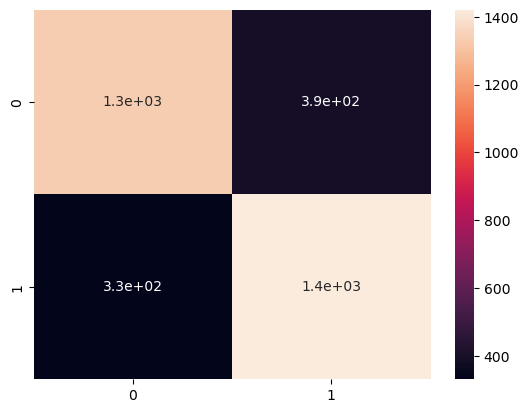

In [37]:
import seaborn as sns
sns.heatmap(cm,annot=True)

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.80      0.77      0.79      1726
        True       0.78      0.81      0.80      1752

    accuracy                           0.79      3478
   macro avg       0.79      0.79      0.79      3478
weighted avg       0.79      0.79      0.79      3478



In [39]:
df2=pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
df2.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.00,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.00,False,0.00,9.00,0.00,2823.00,0.00,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.00,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.00,False,0.00,6652.00,0.00,181.00,585.00,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.00,False,10.00,0.00,635.00,0.00,0.00,Brence Harperez


In [40]:
df2.shape

(4277, 13)

In [41]:
df2.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')

In [42]:
sub=pd.DataFrame(df2['PassengerId'])
sub

,PassengerId
0,0013_01
1,0018_01
2,0019_01
3,0021_01
4,0023_01
...,...
4272,9266_02
4273,9269_01
4274,9271_01
4275,9273_01


In [43]:
df3=pre_processing(df2)
df3.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
0,27.00,0.00,0.00,0.00,0.00,0.00,0,1,0,1,0,0,0,1,1,0
1,19.00,0.00,9.00,0.00,2823.00,0.00,1,0,0,1,0,0,0,1,1,0
2,31.00,0.00,0.00,0.00,0.00,0.00,0,1,0,1,0,0,0,1,0,1
3,38.00,0.00,6652.00,0.00,181.00,585.00,0,1,0,1,0,0,0,1,1,0
4,20.00,10.00,0.00,635.00,0.00,0.00,1,0,0,1,0,0,0,1,1,0


In [44]:
df3.isnull().sum()

Age                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
CryoSleep_False              0
CryoSleep_True               0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
VIP_False                    0
VIP_True                     0
dtype: int64

In [45]:
pred1=clf.predict(df3)

In [46]:
pred1

array([ True, False,  True, ..., False,  True, False])

In [47]:
sub['Transported']=pred1

In [48]:
sub['Transported'].value_counts()

True     2273
False    2004
Name: Transported, dtype: int64

In [49]:
sub.to_csv('submission.csv',index=False)